### Machine Learning


### Load necessary libraries

In [1]:
import matplotlib.pyplot as plt 
import matplotlib

from typing_extensions import TypeVarTuple
# load the zip file
import zipfile
import fnmatch
import os
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util
import skimage

from numpy import *

from PIL import Image

from sklearn import *

import pandas as pd

from sklearn.model_selection import train_test_split

from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
#note I had to run the file on google colab since my processor was too weak
from google.colab import drive

#connect to google drive
drive.mount("/content/gdrive", force_remount=True)
%cd gdrive/My\ Drive/Colab_Notebooks/Machine_Learning_CS4487/Machine_Learning_CS4487

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab_Notebooks/Machine_Learning_CS4487/Machine_Learning_CS4487


### Data Load

In [39]:
# open the original data folder
filename = './data/data.zip'
zfile = zipfile.ZipFile(filename, 'r')

# create a
X = []
Y = []

for name in zfile.namelist():

    # check file is an image
    if fnmatch.fnmatch(name, "*.png"): 

        # get file name
        (fdir1, fname)  = os.path.split(name)     
        # get classes (orginal or manipulated)
        (_, fclass) = os.path.split(fdir1)  

        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        imagesize = (100,100)
        #image = matplotlib.image.imread(myfile)
        #image = matplotlib.rgb2gray(imread('image.png'))
        image = skimage.io.imread(myfile, as_gray=True)
        image_resized = resize(image, imagesize, anti_aliasing=True)

        #image = Image.open(myfile)
        #image = image.resize((50,50),Image.ANTIALIAS)
        # convert to grayscale
        #img = skimage.color.rgb2gray(skimage.color.rgba2rgb(image))
        myfile.close()
        
        # append data
        X.append(image_resized)
        Y.append(fclass)

Ratio of Manipulated Picitures in Dataset: 0.6666666666666666


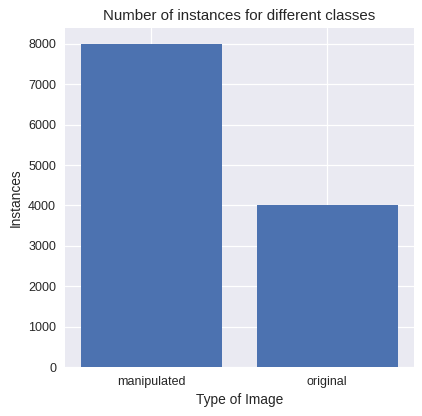

In [48]:
plt.figure(figsize = (5,5), dpi = 90)
plt.style.use("seaborn")
plt.title("Number of instances for different classes")
plt.bar(x = ["manipulated", "original"], height = [Y.count('manipulated'), Y.count('original')])
plt.ylabel("Instances")
plt.xlabel("Type of Image")
print("Ratio of Manipulated Picitures in Dataset: " + str(Y.count('manipulated')  / (Y.count('original')+Y.count('manipulated'))))

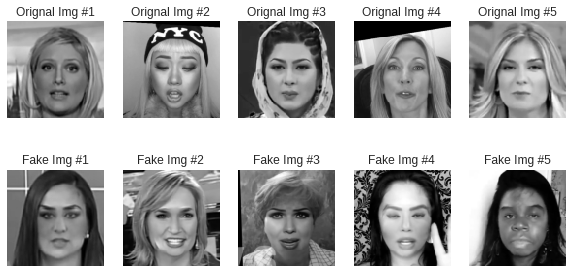

In [5]:
df = pd.DataFrame(data = {"Image": X, "Class": Y})

# make a montage
fakes = df[df["Class"]=="original"].head()["Image"]
orignals = df[df["Class"]=="manipulated"].head()["Image"]
    
# create figure
fig = plt.figure(figsize=(10, 5))
  
# setting values to rows and column variables
rows = 2
columns = 5

position = 1
for i in fakes: 
  
  fig.add_subplot(rows, columns, position)
  plt.imshow(i, cmap='gray', interpolation='nearest')
  plt.title("Orignal Img #"+ str(position))
  plt.axis('off')
  position = position +1

for i in orignals: 
  
  fig.add_subplot(rows, columns, position)
  plt.imshow(i, cmap='gray', interpolation='nearest')
  plt.title("Fake Img #" + str(position-5))
  plt.axis('off')
  position = position +1

plt.show()
#plt.savefig("modified images")

#### Image Flattening

In [6]:
flattend_X = empty((len(X), prod(imagesize)))
for i,img in enumerate(X):
    flattend_X[i,:] = ravel(img)
Y = asarray(Y)  # convert list to numpy array
X = flattend_X
print(X.shape)
print(Y.shape)

(12000, 10000)
(12000,)


### Normalization

In [7]:
# Normalization: sklearn.preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
X = scaler.fit_transform(X)   

In [8]:
#pca = decomposition.PCA(n_components=50)

svd = decomposition.TruncatedSVD(n_components=50)
#transformed x data
X_svd = svd.fit_transform(X)

In [9]:
#method used for splitting the data into training and testing partitions
trainX, testX, trainY, testY = train_test_split(X_svd, Y, test_size=0.2, random_state=77)

#trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.1, random_state=1)

In [18]:


# dict to store evaluation results
predYtest = {}

# define a function for evaluation
def evaluate_model(Model, Model_Name, class_names, trainX=trainX, testX=testX, 
                   trainY=trainY, testY=testY, skip_train=False):
    
    for i in [[trainX, trainY, "Train"], [testX, testY, "Test"]]:
        X = i[0]
        Y = i[1]
        Set_Name = i[2]
        
        if skip_train == True and Set_Name == "Train":
            continue
        
        print("----------------------------------------------------------------")
        print("Evaluation of " + Model_Name + " on " + Set_Name +  "-Set")

        #doing the prediction
        Y_hat = Model.predict(X)
        predYtest[Model_Name] = Y_hat

        #outputing accuracy, precision, recall and the confusion matrix
        print("Accuracy Score: {:.2f}".format(metrics.accuracy_score(Y, Y_hat)))
        
        confusion_matrix = metrics.confusion_matrix(Y, Y_hat)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_names)
        cm_display.plot(cmap = 'Blues', ax = plt.figure(figsize=(2,2), dpi=100).add_axes([0, 0, 1, 1])) 
        plt.grid(False)
        plt.xticks(rotation=40)
        plt.show() 
        
    print("----------------------------------------------------------------")

#for model_name in clfs.keys():
 #   evaluate_model(clfs[model_name], model_name, ["no_face", "face"], trainXn, testXn)

In [31]:
clfs = {}
# setup all the parameters and models
exps = {
    #'svm-lin': {
     #   'paramgrid': {'C': logspace(-2,3,5)},
      #  'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,5), 'gamma': logspace(-4,3,5) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [3,4]},
        'clf': svm.SVC(kernel='poly') },
    }

def do_cross_validation_search(exps):

  for model_name in exps.keys():
      paramgrid = exps[model_name]['paramgrid']
      estimator = exps[model_name]['clf']

      clf = model_selection.GridSearchCV(estimator, paramgrid, cv=10, n_jobs=-1)
      clf.fit(trainX[0:500], trainY[0:500])
      print("Best cross-validation for {} score is: {:.3f}, with parameters {} ".format(
                                                                              model_name,
                                                                              clf.best_score_, 
                                                                              clf.best_params_))
      #clfs[model_name] = clf
do_cross_validation_search(exps)

Best cross-validation for svm-rbf score is: 0.652, with parameters {'C': 0.01, 'gamma': 0.0001} 
Best cross-validation for svm-poly score is: 0.656, with parameters {'C': 0.1291549665014884, 'degree': 3} 


----------------------------------------------------------------
Evaluation of SVM Poly on Train-Set
Accuracy Score: 0.67


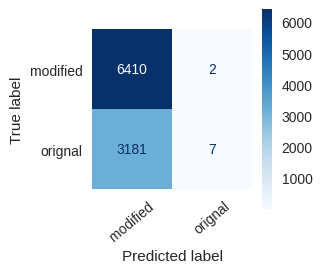

----------------------------------------------------------------
Evaluation of SVM Poly on Test-Set
Accuracy Score: 0.66


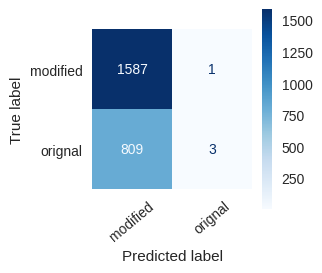

----------------------------------------------------------------


In [36]:
SVM_poly = svm.SVC(kernel='poly', C = 0.129, degree=3)
SVM_poly.fit(trainX, trainY)
evaluate_model(SVM_poly, "SVM Poly", ["modified", "orignal"], trainX, testX)

In [34]:
exps2 = {
    'knn': {
        'paramgrid': {'n_neighbors': arange(2,50,2)},
        'clf': neighbors.KNeighborsClassifier() },
    }
do_cross_validation_search(exps2)


Best cross-validation for knn score is: 0.652, with parameters {'n_neighbors': 40} 


----------------------------------------------------------------
Evaluation of K Nearest Neighbour on Train-Set
Accuracy Score: 0.67


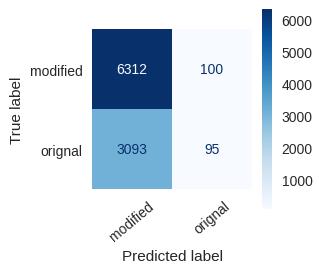

----------------------------------------------------------------
Evaluation of K Nearest Neighbour on Test-Set
Accuracy Score: 0.66


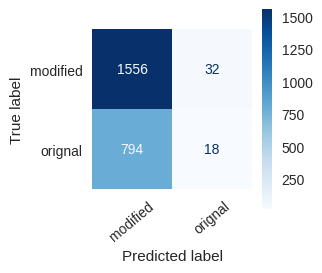

----------------------------------------------------------------


In [37]:
knn = neighbors.KNeighborsClassifier(n_neighbors=40)
knn.fit(trainX, trainY)
evaluate_model(knn, "K Nearest Neighbour", ["modified", "orignal"], trainX, testX)